In [204]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%aimport ichol_V
%aimport ichol
%aimport simulation
%aimport ichol_adagrad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [76]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis

import ichol, ichol_V, ichol_adagrad
import simulation

# No spike regression

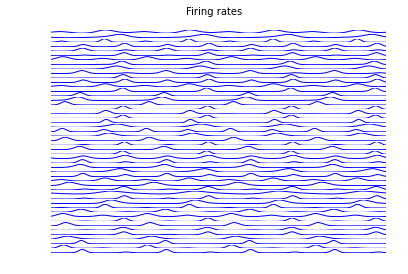

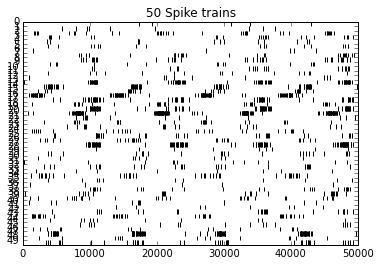

In [186]:
np.random.seed(0)

T = 50000
p = 0
L = 2
N = 50

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, w)
x = np.empty((T, L), dtype=float)
# x[:T // 2, 0] = high
# x[T // 2:, 0] = low
# x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
x[:, 0] = 2 * np.sin(0.0005 * np.arange(T) + np.pi)
x[:, 1] = 2 * np.sin(0.001 * np.arange(T))

for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p*N, N))
b[0, :] = low

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
_, ax = subplots(N, sharex=True)
for n in range(N):
    ax[n].plot(rate[:, n])
    ax[n].axis('off')
suptitle('Firing rates')

figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

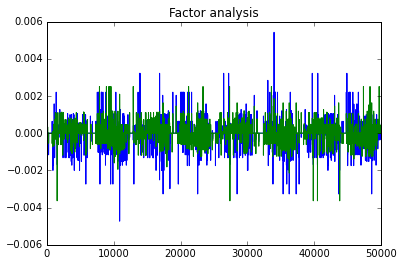

In [187]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')

In [72]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-4
w[1] = 1e-4

from model_chol import train
%lprun -f decompV.train decompV.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=50, tol=1e-4, verbose=True)


Iteration[1]
lower bound = -16835842533.68340
increment = 83228461.8961639404
time = 0.26s
change in alpha = 0.0000000000
change in beta = 0.9999998299
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -4208968383.92803
increment = 12626874149.7553653717
time = 0.27s
change in alpha = 0.0000000000
change in beta = 0.9945746844
change in posterior mean = 0.0437851674
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -1052247554.46732
increment = 3156720829.4607110023
time = 0.27s
change in alpha = 0.0000000000
change in beta = 0.9853354750
change in posterior mean = 0.0537902660
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -263066855.46623
increment = 789180699.0010941029
time = 0.26s
change in alpha = 1.0899781114
change in beta = 0.9607944363
change in posterior mean = 0.114810


Iteration[1]
lower bound = -9609430.61346
increment = 14596673401323.4785156250
time = 2.15s
change in alpha = 4.4976700294
change in beta = 0.9998000400
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -2440724.83608
increment = 7168705.7773804497
time = 2.19s
change in alpha = 1.5407819462
change in beta = 0.9994565612
change in posterior mean = 0.0167554488
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -630143.42349
increment = 1810581.4125919119
time = 2.28s
change in alpha = 0.2400302852
change in beta = 0.9985235871
change in posterior mean = 0.0245129902
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -173421.09143
increment = 456722.3320578977
time = 2.24s
change in alpha = 0.2212248920
change in beta = 0.9959926966
change in posterior mean = 0.0514365714
change in pri

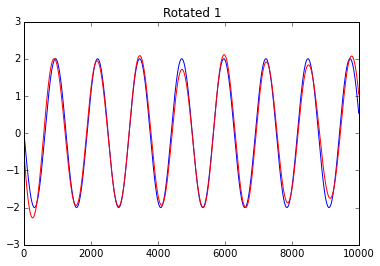

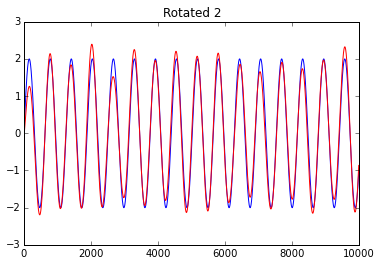

In [121]:
var = np.empty(L, dtype=float)
var[0] = 10
var[1] = 10
w = np.empty(L, dtype=float)
w[0] = 1e-6
w[1] = 1e-5
m1 = None
lbound, m1, a1, b1, var1, w1, a0, b0, elapsed, converged = ichol_V.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=50, tol=1e-5, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

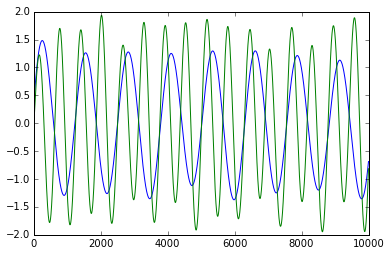

In [122]:
plot(m1)


Iteration[1]
lower bound = -1077011.36039
increment = 15364957484.5100269318
time = 9.36s
change in alpha = 4.4349501868
change in beta = 0.9999000104
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -418092.12077
increment = 658919.2396221523
time = 10.23s
change in alpha = 1.8425391696
change in beta = 0.9997282264
change in posterior mean = 0.0031287061
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -186645.26993
increment = 231446.8508421074
time = 9.24s
change in alpha = 1.9211783227
change in beta = 0.9992614438
change in posterior mean = 0.0086749742
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -104818.75155
increment = 81826.5183789056
time = 9.26s
change in alpha = 0.8536927672
change in beta = 0.9979938824
change in posterior mean = 0.0226238041
change in prior var

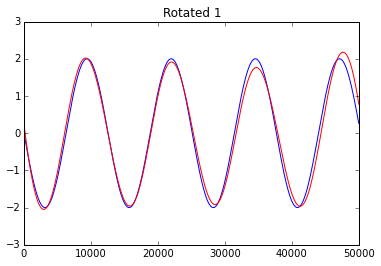

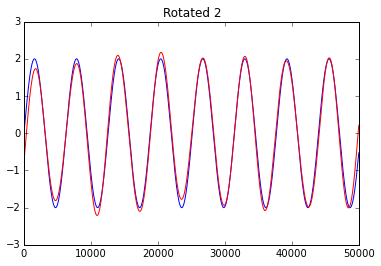

In [178]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-8
w[1] = 1e-7
m1 = None
lbound, m1, a1, b1, var1, w1, a0, b0, elapsed, converged = ichol_V.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=50, tol=1e-5, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

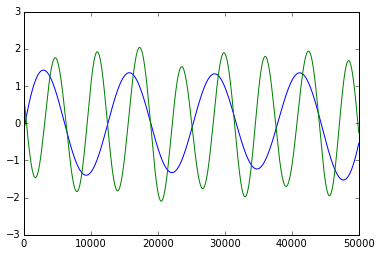

In [179]:
plot(m1)

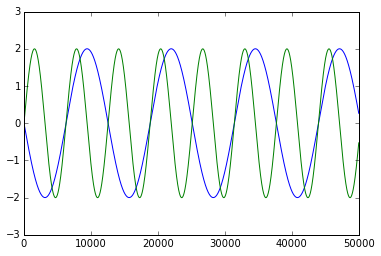

In [142]:
plot(x)


Iteration[1]
lower bound = -1754801.88084
increment = 901308.2402276350
time = 8.95s
change in alpha = 0.8386992584
change in beta = 0.4472135955
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -1407309.89947
increment = 347491.9813766407
time = 8.96s
change in alpha = 0.0328389905
change in beta = 0.2452970968
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -1201242.07330
increment = 206067.8261702706
time = 8.99s
change in alpha = 0.0256980878
change in beta = 0.1802194383
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -1059579.02226
increment = 141663.0510421649
time = 8.98s
change in alpha = 0.0231974112
change in beta = 0.1459491690
change in posterior mean = 0.0000000000
change in prior varia

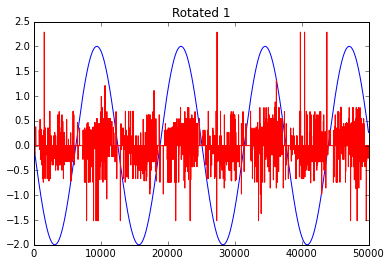

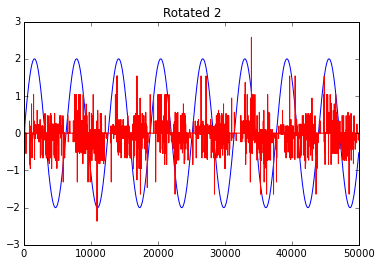

In [208]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-8
w[1] = 1e-7
m1 = None
lbound, m1, a1, b1, var1, w1, a0, b0, elapsed, converged = ichol_adagrad.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=50, tol=1e-5, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))